<a href="https://colab.research.google.com/github/matteolimoncini/COVID-19-search-engine/blob/main/COVID_19_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install split-folders

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
from PIL import Image 
import IPython.display as display

In [3]:
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%capture
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip sarscov2-ctscan-dataset.zip -d sarscov2-ctscan-dataset
!rm sarscov2-ctscan-dataset.zip

check images size

a b
c d
e f

In [5]:
folder_images = "./sarscov2-ctscan-dataset"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

sizes = []
for keys,values in size_images.items():
  sizes.append((values.get('width'),values.get('heigth')))


max_width = max(sizes,key=lambda item:item[0])[0]
min_width = min(sizes,key=lambda item:item[0])[0]
max_heigth = (max(sizes,key=lambda item:item[1])[1])
min_heigth = (min(sizes,key=lambda item:item[1])[1])
print ('max width images: '+str(max_width)+'\n'+'min width images: '+str(min_width))
print ('max heigth images: '+str(max_heigth)+'\n'+'min heigth images: '+str(min_heigth))

max width images: 534
min width images: 182
max heigth images: 416
min heigth images: 119


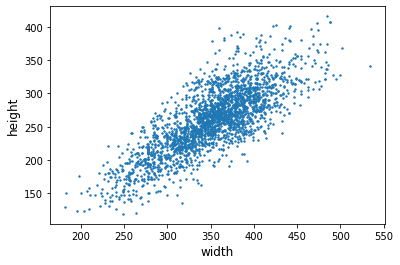

In [6]:
x = [i[0] for i in sizes]
y = [i[1] for i in sizes]
plt.scatter(x, y, s=2)
plt.xlabel('width', fontsize='large')
plt.ylabel('height', fontsize = 'large')
plt.show()

Is the dataset balanced?

In [7]:
covid = len(os.listdir('./sarscov2-ctscan-dataset/COVID'))
no_covid = len(os.listdir('./sarscov2-ctscan-dataset/non-COVID'))

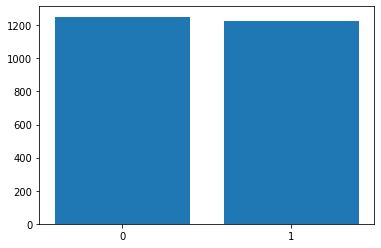

In [8]:
plt.bar([0,1], [covid, no_covid])
plt.xticks(np.arange(0, 2, 1))
plt.show()

In [9]:
TRAINING_DIR = '/content/splitted_img/train'
VALIDATION_DIR = '/content/splitted_img/val'
TEST_DIR = '/content/splitted_img/test'
IMG_SIZE = 256
BATCH_SIZE = 64
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 10

split dataset in a random way. 80% training, 10% test, 10% validation

In [10]:
splitfolders.ratio("./sarscov2-ctscan-dataset", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:01, 1863.33 files/s]


In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale', 
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

Found 1984 files belonging to 2 classes.
Found 247 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


normalize pixel values from 0 to 1 insted of 0;255

In [12]:
def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
train_ds = normalize_data(train_dataset, True)
val_ds = normalize_data(val_dataset, False)
test_ds = normalize_data(test_dataset)

In [13]:
for x, y in train_ds.take(1):
  print(x[0], y[0])

tf.Tensor(
[[[0.8336834 ]
  [0.8186971 ]
  [0.8043389 ]
  ...
  [0.80535793]
  [0.7981465 ]
  [0.79215693]]

 [[0.82943547]
  [0.8201996 ]
  [0.8109375 ]
  ...
  [0.7987592 ]
  [0.7942459 ]
  [0.78864896]]

 [[0.8249694 ]
  [0.8189798 ]
  [0.8115503 ]
  ...
  [0.797169  ]
  [0.7948114 ]
  [0.79256684]]

 ...

 [[0.8334406 ]
  [0.8340271 ]
  [0.8352942 ]
  ...
  [0.7884498 ]
  [0.78986347]
  [0.7923677 ]]

 [[0.8262938 ]
  [0.82908446]
  [0.83134633]
  ...
  [0.7896753 ]
  [0.7896753 ]
  [0.7896753 ]]

 [[0.81655717]
  [0.8180371 ]
  [0.8225031 ]
  ...
  [0.8095049 ]
  [0.8156027 ]
  [0.8167127 ]]], shape=(256, 256, 1), dtype=float32) tf.Tensor([1.], shape=(1,), dtype=float32)


In [14]:
def first_cnn():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

In [15]:
first_try_cnn = first_cnn()

In [16]:
first_try_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [18]:
EPOCHS=8

In [19]:
#@title Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [20]:
plot_training = PlotTraining(sample_rate=10, zoom=1)

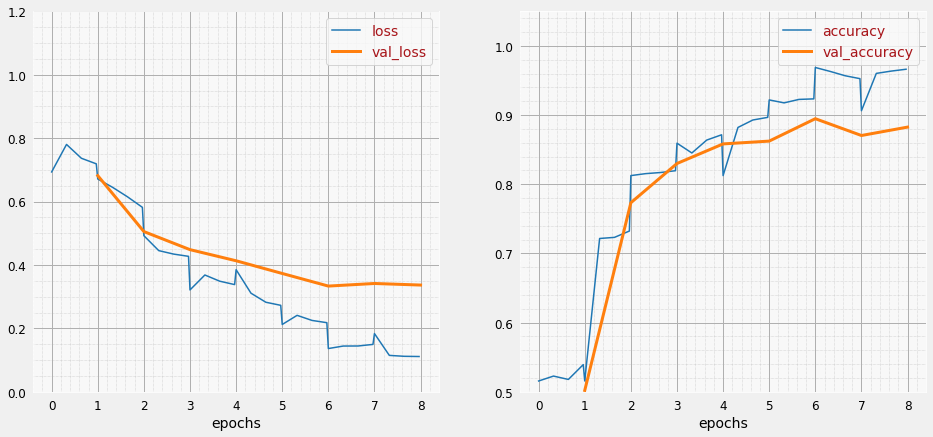

31/31 [==============================] - 56s 2s/step - loss: 0.1113 - accuracy: 0.9662 - val_loss: 0.3366 - val_accuracy: 0.8826


In [21]:
history = first_try_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training]
)